<a href="https://colab.research.google.com/github/Harsha2509/AIMLTraining_Harsha/blob/main/Day_07_PSU_Object_Detection_FasterRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Object Detection
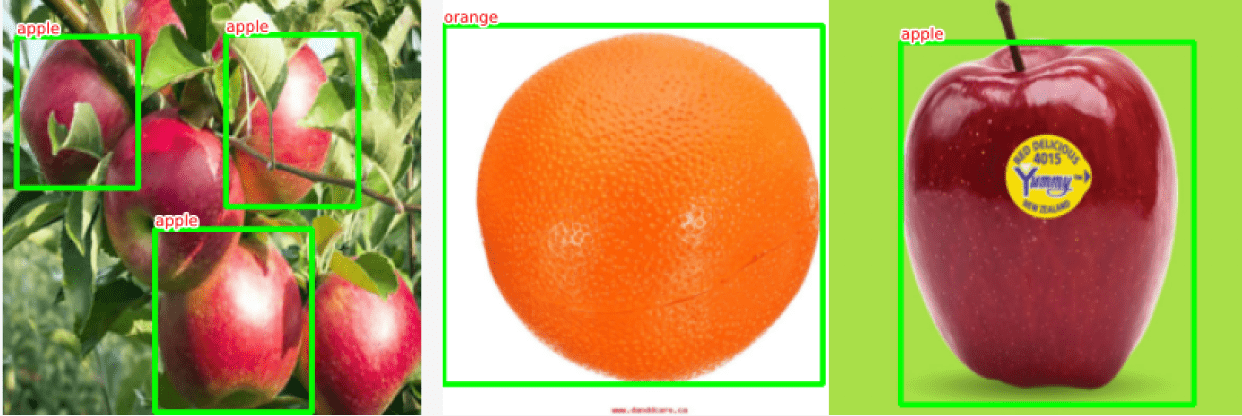

<hr/>
Object detection is a computer vision and image processing related technique that deals with detecting instances of semantic objects in an image or video. Unlike image classification where labeling object is sufficient object detection involves identifying the position and the boundaries of an object, and only then classifying it into the corresponding categories.

<hr/>
<b>Dataset:</b> In this project we are dealing with fruit images dataset. The dataset include the pictures of fruits as well as the `.xml` files that among other things describe the ground truth bounding box coordinates around the objects.
<br/>
<b>The main question of the project is:</b> Given the training images with ground truth bounding boxes can we detect fruits in unseen images?

<b>Methods and Findings:</b> We are leveraging an object detection model known as Faster R-CNN to detect our fruits. In order to be able to utilize the model we are creating a dataset class to capture the images and preprocess them. The results are fed into the model.

1. Create a dataset class to read and preprocess the data.

2. Define our model with corresponding attributes.

3. Track the model's performance.

In [13]:
!pip install -q torch_snippets lovely-tensors torchinfo

from torch_snippets import *
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.patches as patches
display.set_matplotlib_formats('svg')

from torchinfo import summary

import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from xml.etree import ElementTree as et
device = 'cuda' if torch.cuda.is_available() else 'cpu'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 70.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 82.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 106.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.9/172.9 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 105.1 MB/s eta 0:0

<ipython-input-13-1daa5d9ef347>:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [ ]:
# !rm -r dataset/

rm: cannot remove 'dataset/': No such file or directory


In [5]:
# unzip the dataset
!mkdir dataset
!unzip -q test_zip.zip -d ./dataset
!unzip -q train_zip.zip -d ./dataset

mkdir: cannot create directory ‘dataset’: File exists
replace ./dataset/test/apple_77.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ./dataset/test/apple_77.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ./dataset/test/apple_78.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ./dataset/test/apple_78.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace ./dataset/test/apple_78.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
replace ./dataset/train/apple_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
#!zip -r fruit_dataset.zip dataset

# Reading the Data 📖

The data is not big. It contains $240$ images of fruits in the train folder and $60$ images in the test folder.  
At this part of the project we will:
- retrieve the images
- resize them
- retrieve the objects labels for each image
- retrieve the ground truth bounding boxes of the objects for each image
- resize them accordingly


In [6]:
root = '//content/train.zip/'

# we have four labels
labels = ['background', 'orange', 'apple', 'banana']
label2targets = {l: t for t, l in enumerate(labels)}
targets2label = {t: l for l, t in label2targets.items()}
num_classes = len(targets2label)

In [7]:
def plot_img_bbox(img, target):
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in target:
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        a.add_patch(rect)
    plt.show()

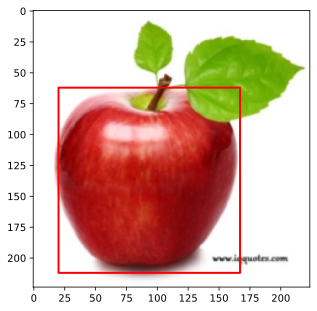

In [15]:
def preprocess_img(img):
    img = torch.tensor(img).permute(2, 0 ,1)
    return img.float()

class FruitsDataset(Dataset):
    def __init__(self, root=root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.img_paths = sorted(Glob(self.root + '/*.jpg'))
        self.xlm_paths = sorted(Glob(self.root + '/*.xml'))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        w, h = 224, 224
        img_path = self.img_paths[idx]
        xlm_path = self.xlm_paths[idx]
        img = Image.open(img_path).convert('RGB')
        W, H = img.size
        img = np.array(img.resize((w, h),
                       resample=Image.Resampling.BILINEAR))/255.
        xlm = et.parse(xlm_path)
        objects = xlm.findall('object')
        labels = []
        boxes = []
        for obj in objects:
            label = obj.find('name').text
            labels.append(label)
            XMin = float(obj.find('bndbox').find('xmin').text)
            YMin = float(obj.find('bndbox').find('ymin').text)
            XMax = float(obj.find('bndbox').find('xmax').text)
            YMax = float(obj.find('bndbox').find('ymax').text)
            bbox = [XMin / W, YMin / H, XMax / W, YMax / H]
            bbox = (bbox * np.array([w, h, w, h])).astype(np.int16).tolist()
            boxes.append(bbox)
        target = {}
        target['labels'] = torch.tensor([label2targets[label] for label in labels]).long()
        target['boxes'] = torch.tensor(boxes).float()
        img = preprocess_img(img)
        return img, target

    def collate_fn(self, batch):
        return tuple(zip(*batch))

val_root = '/content/dataset/test/'

train_ds = FruitsDataset(val_root)
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=train_ds.collate_fn)

val_ds = FruitsDataset(root=val_root)
val_dl = DataLoader(val_ds, batch_size=2, shuffle=True, collate_fn=val_ds.collate_fn)

img, target = train_ds[10]
plot_img_bbox(img.permute(1,2,0), target['boxes'])

# Model evaluation 🤖

Let's try to understand the core phases of the prediction process our model is using:
1. Anchor Boxes:
These serve as a replacement of the selective search based region proposals.
- <b>Key Idea</b> Typically the majority of the objects have a similar shape e.g. a ground truth bounding box for a person will have a greater height than width.
 - The inspection of the ground truth bounding boxes of the objects present in the images helps to build a descent idea about the height and the width of the objects.
 - Albeit, some images can be scaled. This will result in the the distortion of the object's height and width. Hence, an aspect ration $\frac{\text{height}}{\text{width}}$ is computed from the ground truth values for objects of each class.
 - After completion of the previous two steps we can define the <span style="background-color: green;">anchor boxes</span> with heights and widths representing the majority of objects' bounding boxes within certain class for our dataset.

At this stage we have the anchor boxes of certain height/width for each class of objects. However, how one can use such boxes to detect the objects of those classes in the images?  
The answer is by sliding:
- Slide each anchor box over an image from top left to bottom right.

2. Region Proposal Network (RPN)
We pass the image's crops identified by anchor boxes to the RPN model. It then suggests the likelihood of the crop containing an object.
- For each possible crop compute the IoU$^*$. Those boxes that have higher IoU then some threshold will get a label that mentions that they contain an object. Others will be labeled $0$.
All the candidate crops that have small IoU will be discarded while training.

Finally, we can perform non-max supression (since multiple crops can contain the same object) to identify the region candidate that has the highest probability of containing an object and eliminate other region candidates that have a high overlap with it.

At this point we managed to build up bounding boxes that are likely to contain the objects. Are we done? Not yet. We should also predict what kind the class of the object around which the bounding box has been created.

3. Classification and Regression
Here we are using something known as RoI pooling layer and pass both the image featured learned from the CNN as well as the candidate bounding boxes to RoI.  
RoI pooling is needed to convert each feature map into a fixed dimension map that onward would be passed to fully connected network (FCN). The conversion goes like this:  
 3.1. Take the feature map and the candidate bounding box (i.e. region proposal).  
 3.2. Divide the candidate bounding box into equal-sized sections. The number of this sections is the same as the dimension of the output.  
 3.3 Do max-pooling for these sections.

So, RoI lets us to form feature maps of fixed size from a list of candidate bounding boxes of different size.
The remaining is straightforward:
- Flatten the RoI outputs pass to FCN that predicts:

a) The class of the object.

b) The amount of offset for the candidate bounding box to maximize the IoU with the ground truth.

$^*$Remark: Intersection over Union (IoU) is a measure of accuracy i.e. how overlapping the predicted and actual bounding boxes are
$$ IoU = \frac{\text{Area of overlapping region}}{\text{Area of combined region}} $$



<hr/>
All of this is done behind the scenes. Here we are not going to train the model from scratch and go through all those phases (partly because we don't possess the computational resources to do so). Hence, we will use an already pretrained mode from pytorch library.

In [16]:
def get_model():
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    #print(in_features)
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# test the model
imgs, targets = next(iter(train_dl))
imgs = list(img.to(device) for img in imgs)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

model = get_model().to(device)
print(model(imgs, targets))
summary(model, (1,3,224,224))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 269MB/s]


{
    'loss_classifier': tensor grad NllLossBackward0 cuda:0 1.526,
    'loss_box_reg': tensor grad DivBackward0 cuda:0 0.325,
    'loss_objectness': tensor grad BinaryCrossEntropyWithLogitsBackward0 cuda:0 0.011,
    'loss_rpn_box_reg': tensor grad DivBackward0 cuda:0 0.004
}

Layer (type:depth-idx)                                  Output Shape              Param #
FasterRCNN                                              [100, 4]                  --
├─GeneralizedRCNNTransform: 1-1                         [1, 3, 800, 800]          --
├─BackboneWithFPN: 1-2                                  [1, 256, 13, 13]          --
│    └─IntermediateLayerGetter: 2-1                     [1, 2048, 25, 25]         --
│    │    └─Conv2d: 3-1                                 [1, 64, 400, 400]         (9,408)
│    │    └─FrozenBatchNorm2d: 3-2                      [1, 64, 400, 400]         --
│    │    └─ReLU: 3-3                                   [1, 64, 400, 400]         --
│    │    └─MaxPool2d: 3-4                              [1, 64, 200, 200]         --
│    │    └─Sequential: 3-5                             [1, 256, 200, 200]        (212,992)
│    │    └─Sequential: 3-6                             [1, 512, 100, 100]        1,212,416
│    │    └─Sequential: 3-7              

EPOCH: 0.067  trn_loss: 2.153  trn_loc_loss: 1.603  trn_regr_loss: 0.533  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.010  (1.54s - 44.56s remaining)
EPOCH: 0.133  trn_loss: 0.849  trn_loc_loss: 0.517  trn_regr_loss: 0.311  trn_loss_objectness: 0.016  trn_loss_rpn_box_reg: 0.005  (2.24s - 31.41s remaining)
EPOCH: 0.200  trn_loss: 0.278  trn_loc_loss: 0.137  trn_regr_loss: 0.136  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.003  (2.92s - 26.32s remaining)
EPOCH: 0.267  trn_loss: 0.364  trn_loc_loss: 0.182  trn_regr_loss: 0.168  trn_loss_objectness: 0.010  trn_loss_rpn_box_reg: 0.004  (3.61s - 23.46s remaining)
EPOCH: 0.333  trn_loss: 0.678  trn_loc_loss: 0.383  trn_regr_loss: 0.286  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.004  (4.29s - 21.45s remaining)
EPOCH: 0.400  trn_loss: 0.828  trn_loc_loss: 0.482  trn_regr_loss: 0.327  trn_loss_objectness: 0.015  trn_loss_rpn_box_reg: 0.004  (5.02s - 20.07s remaining)
EPOCH: 0.467  trn_loss: 0.261  trn_loc_loss: 0.143  

100%|██████████| 103/103 [00:00<00:00, 11292.10it/s]


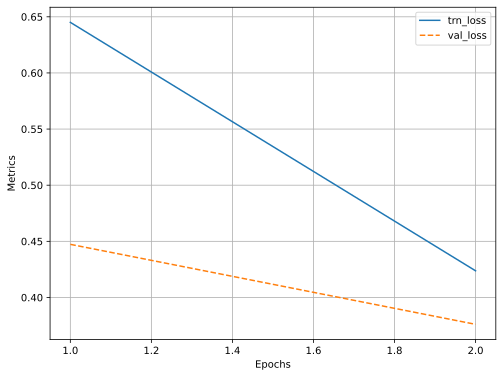

In [17]:
def train_batch(batch, model, optim):
    model.train()
    imgs, targets = batch
    imgs = list(img.to(device) for img in imgs)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optim.zero_grad()
    losses = model(imgs, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optim.step()
    return loss, losses

@torch.no_grad()
def validate_batch(batch, model, optim):
    model.train()
    imgs, targets = batch
    imgs = list(img.to(device) for img in imgs)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optim.zero_grad()
    losses = model(imgs, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

model = get_model().to(device)
optim = torch.optim.SGD(model.parameters(), lr=0.005,
                       weight_decay=5e-4, momentum=0.9)

n_epochs = 2
log = Report(n_epochs)
for e in range(n_epochs):
    for i, batch in enumerate(train_dl):
        N = len(train_dl)
        loss, losses = train_batch(batch, model, optim)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in
                                                                  ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']]
        log.record(e + (i+1)/N, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(),
                   trn_regr_loss=regr_loss.item(), trn_loss_objectness=loss_objectness.item(),
                   trn_loss_rpn_box_reg = loss_rpn_box_reg.item())
    for i, batch in enumerate(val_dl):
        N = len(val_dl)
        loss, losses = validate_batch(batch, model.float(), optim)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in
                                                                  ['loss_classifier', 'loss_box_reg',
                                                                   'loss_objectness', 'loss_rpn_box_reg']]
        log.record(e + (i+1)/N, val_loss=loss.item(), val_loc_loss=loc_loss.item(),
                   val_regr_loss=regr_loss.item(), val_loss_objectness=loss_objectness.item(),
                   val_loss_rpn_box_reg = loss_rpn_box_reg.item())
    log.report_avgs(e+1)
log.plot_epochs(['trn_loss', 'val_loss'])

# Model Testing ⚡

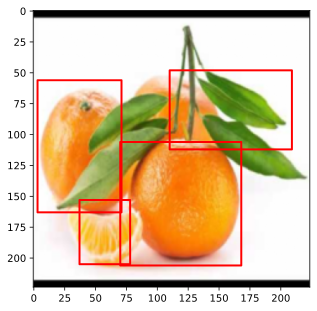

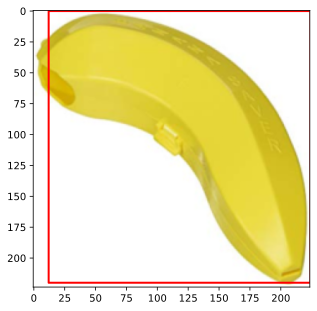

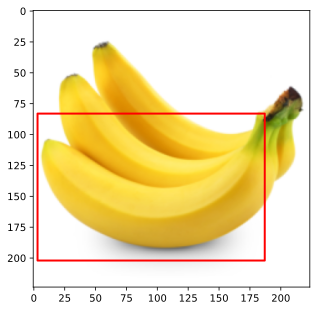

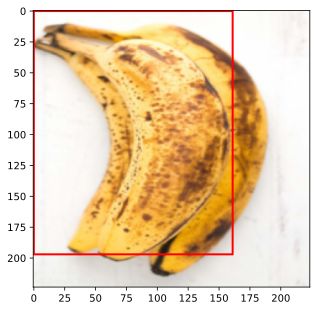

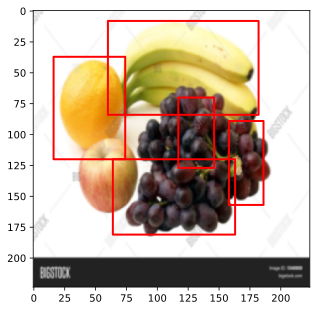

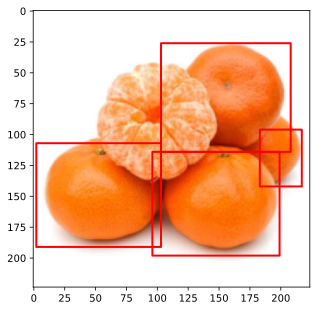

In [18]:
from torchvision.ops import nms

def decode_output(output):
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([targets2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    idxs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[idxs] for tensor in [bbs, confs, labels]]
    if len(idxs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

model.eval()
for i, (images, targets) in enumerate(val_dl):
    imgs = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    if i == 3: break
    images = [im for im in imgs]
    outputs = model(images)
    for i, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        plot_img_bbox(images[i].cpu().permute(1,2,0), bbs)



### Segmentation

- Standard Model for Segmentation can be found here:
  - https://github.com/qubvel/segmentation_models.pytorch.
  - Walkthrough
- YOLOv8
  - Detection and Segmentation
  - https://github.com/ultralytics/ultralytics
  - Segment: https://docs.ultralytics.com/tasks/segment/
  - Detect: https://docs.ultralytics.com/tasks/detect/

## Resources worth Read:
1. Segmentation Survey Paper: https://ieeexplore.ieee.org/document/9356353
2. Detection Blog: https://viso.ai/deep-learning/object-detection/
3. A Comprehensive Study of Real-Time Object Detection Networks Across Multiple Domains: A Survey - https://arxiv.org/abs/2208.10895
4. Object Detection: https://ieeexplore.ieee.org/document/10028728
5. YOLO:https://www.datacamp.com/blog/yolo-object-detection-explained
6. Loss Functions: https://github.com/JunMa11/SegLoss
7. Loss Functions: https://learnopencv.com/iou-loss-functions-object-detection/


**Vision Foundation Model in Segmentation**:
- SAM: Segment Anything Model
- AI model from Meta AI that can "cut out" any object, in any image, with a single click.
- SAM produces high-quality object masks from input prompts such as points or boxes, and it can be used to generate object masks for any image.
- The model is designed and trained to be promptable, so it can transfer zero-shot to new image distributions and tasks.
- SAM uses a variety of input prompts, including points or boxes, to segment objects in images.
- The Segment Anything project also includes the Segment Anything Dataset, which is the largest ever segmentation dataset, with over 1 billion masks on 11M licensed and privacy-respecting images.
- SAM is a starting point for foundation models for image segmentation, and it can reduce the need for task-specific modeling expertise, training compute, and custom data annotation for image segmentation.

- Project: https://segment-anything.com/